In this project we'll be constructing the u-net architecture for a CNN based on the methods outlined in the [original research paper](https://arxiv.org/pdf/1505.04597.pdf). In particular, we will be following the operations shown in the picture:

![1.png](img/1.png)

We'll then train and test the model on a dataset to see how it fares at image segmentation.

First, we define the convolution layer, depicted by two of the blue arrows.

![2.png](img/2.png)

This layer is defined by two passes of a $3 \times 3$ convolution followed by a ReLU activation layer.

In [15]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv(input, channels):
    #First pass
    x = Conv2D(channels, 3, padding='same')(input)
    x = BatchNormalization()(x)     #Batch normalization was introduced after the release of the original u-net paper. We include it here for stability of the model.
    x = Activation('relu')(x)
    #Second
    x = Conv2D(channels, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

We now define a contraction block, meant to be the above `conv` and a $2 \times 2$ max pooling operation.

![3.png](img/3.png)

In [16]:
def encode(input, channels):
    x = conv(input, channels)
    y = MaxPooling2D((2, 2))(x)      #Paper specifies stride 2. For MaxPooling2D, strides is equal to pool_size by default, which is set to 2.

    return x, y

Next is an expansion block, for the expansion half of the diagram. This consists of a $2 \times 2$ transposed convolution, concatenation with the corresponding feature map from the contracting path, and an application of `conv`.

![4.png](img/4.png)

In [17]:
def decode(input, contract_input, channels):
    x = Conv2DTranspose(channels, (2, 2), strides=2, padding='same')(input)
    x = Concatenate()([x, contract_input])
    x = conv(x, channels)

    return x

Now to define the model itself.

In [18]:
channels = 64

def unet(input):
    input = Input(shape=(256, 256, 1))        #The model will take images of this shape.

    #Contraction path
    c1, y1 = encode(input, channels)
    c2, y2 = encode(y1, channels * 2)
    c3, y3 = encode(y2, channels * 4)
    c4, y4 = encode(y3, channels * 8)
    #Connection between contraction and expansion paths
    d = conv(y4, channels * 16)
    #Expansion path
    e1 = decode(d, c4, channels * 8)
    e2 = decode(e1, c3, channels * 4)
    e3 = decode(e2, c2, channels * 2)
    e4 = decode(e3, c1, channels)
    #Final convolution layer
    output = Conv2D(1, 1, activation='sigmoid')(e4)

    return Model(input, output, name='u-net')

Let's compile the model and view a summary.

In [19]:
from tensorflow.keras.optimizers import Adam

input_shape = (256, 256, 1)
model = unet(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "u-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

To actually put the model into use, we'll be using the Electron Microscopy Dataset sub-volumes, found [here](https://www.epfl.ch/labs/cvlab/data/data-em/). We have, ahead of time, taken the `TIF` stacks and unstacked them into individual images, sliced each of these images into six $256 \times 256$ pieces, and dropped over 90% of them. This leaves us with 132 images and masks each. The reason for excluding so many is to give us an opportunity to use image generation for our dataset as an exercise. Our u-net model will be training to detect mitochondria.

First, we need to load the dataset.

In [20]:
import os
import numpy as np
from PIL import Image

def load_data(image_folder, mask_folder):
    image_paths = sorted(os.listdir(image_folder))
    mask_paths = sorted(os.listdir(mask_folder))

    images = []
    masks = []

    for image_path, mask_path in zip(image_paths, mask_paths):
        image = np.array(Image.open(os.path.join(image_folder, image_path))) / 255.0        #Also normalizing.
        mask = np.array(Image.open(os.path.join(mask_folder, mask_path))) / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [21]:
image_folder = 'dataset\\images'
mask_folder = 'dataset\\masks'

images, masks = load_data(image_folder, mask_folder)

images = np.expand_dims(images, -1)     #Jacking up the rank by 1 for later image generation.
masks = np.expand_dims(masks, -1)

We split up the dataset into training and testing categories.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.25, random_state=13)

Taking a quick sanity check of some of the training data:

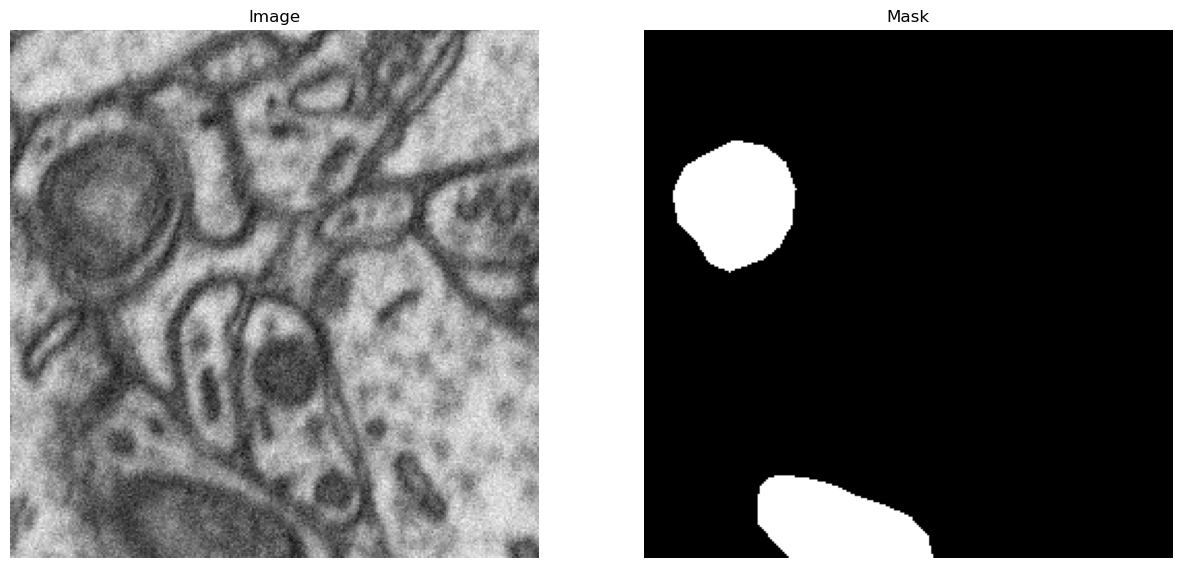

In [23]:
import matplotlib.pyplot as plt

image_index = np.random.randint(0, len(X_train))

plt.figure(figsize=(15, 10))
#Image
plt.subplot(121)
plt.imshow(X_train[image_index], cmap='gray')
plt.title('Image')
plt.axis('off')
#Mask
plt.subplot(122)
plt.imshow(y_train[image_index], cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

After running the above block a few times, everything seems look to be in order. Let's boot up image generation.

In [24]:
from keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rotation_range=90,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.5,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='reflect')

mask_datagen = ImageDataGenerator(rotation_range=90,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  shear_range=0.5,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='reflect',
                                  preprocessing_function = lambda x: np.where(x > 0, 1, 0).astype(x.dtype))     #Ensuring a binary mask.

In [25]:
batch_size = 16
seed = 13       #So that the transformations applied to images and masks coincide.

In [26]:
#Images
train_image_generator = image_datagen.flow(X_train, seed=seed, batch_size=batch_size)
test_image_generator = image_datagen.flow(X_test, seed=seed, batch_size=batch_size)
#Masks
train_mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=batch_size)
test_mask_generator = mask_datagen.flow(y_test, seed=seed, batch_size=batch_size)

def data_generator(image_generator, mask_generator):
    generator = zip(train_image_generator, train_mask_generator)
    for (image, mask) in generator:
        yield (image, mask)

train_generator = data_generator(train_image_generator, train_mask_generator)
test_generator = data_generator(test_image_generator, test_mask_generator)

Taking a quick look at the data our generator spits out:

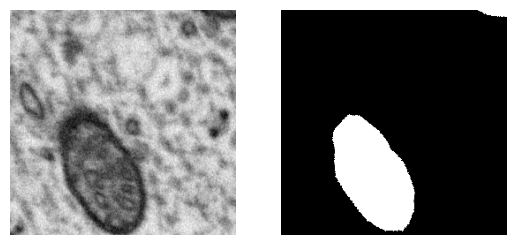

In [27]:
x = train_image_generator.next()
y = train_mask_generator.next()

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.axis('off')
    plt.show()

After running it a few times, it seems to be alright. Before training the model, let's see what it would predict, just for fun.

1/1 [==============================] - 0s 14ms/step


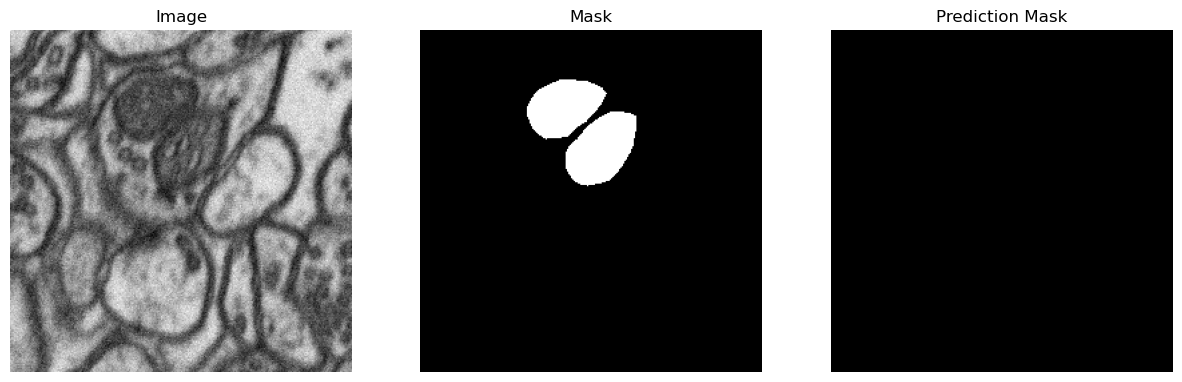

In [32]:
test_image_number = np.random.randint(0, len(X_test))
test_image = X_test[test_image_number]
true_mask = y_test[test_image_number]
test_image_norm = test_image[:,:,0][:,:,None]
test_image_input = np.expand_dims(test_image_norm, 0)
prediction = (model.predict(test_image_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_image[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(232)
plt.title('Mask')
plt.imshow(true_mask[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(233)
plt.title('Prediction Mask')
plt.imshow(prediction, cmap='gray')
plt.axis('off')

plt.show()

But of course, without any training, the model will always predict the entirety of the mask to be background.

The next step is training the model, which we'll do for 25 epochs.

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 25
steps_per_epoch = len(X_train) // batch_size * 8                                                #Trying to keep it around 40-50 for reasonable compute time.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)       #Just in case.

In [34]:
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch)

Epoch 1/25
48/48 [==============================] - 43s 632ms/step - loss: 0.3145 - accuracy: 0.9258 - val_loss: 0.8347 - val_accuracy: 0.0916
Epoch 2/25
48/48 [==============================] - 28s 588ms/step - loss: 0.1437 - accuracy: 0.9749 - val_loss: 0.5906 - val_accuracy: 0.8444
Epoch 3/25
48/48 [==============================] - 27s 580ms/step - loss: 0.1091 - accuracy: 0.9813 - val_loss: 0.3907 - val_accuracy: 0.9282
Epoch 4/25
48/48 [==============================] - 28s 583ms/step - loss: 0.0961 - accuracy: 0.9822 - val_loss: 0.2559 - val_accuracy: 0.9353
Epoch 5/25
48/48 [==============================] - 28s 583ms/step - loss: 0.0810 - accuracy: 0.9857 - val_loss: 0.9223 - val_accuracy: 0.6420
Epoch 6/25
48/48 [==============================] - 28s 585ms/step - loss: 0.0740 - accuracy: 0.9863 - val_loss: 6.3150 - val_accuracy: 0.0873
Epoch 7/25
48/48 [==============================] - 28s 581ms/step - loss: 0.0768 - accuracy: 0.9839 - val_loss: 1.6137 - val_accuracy: 0.5781

In [35]:
model.save_weights('model_weights.h5')

We've now trained the model. Let's take a look at its accuracy and loss.

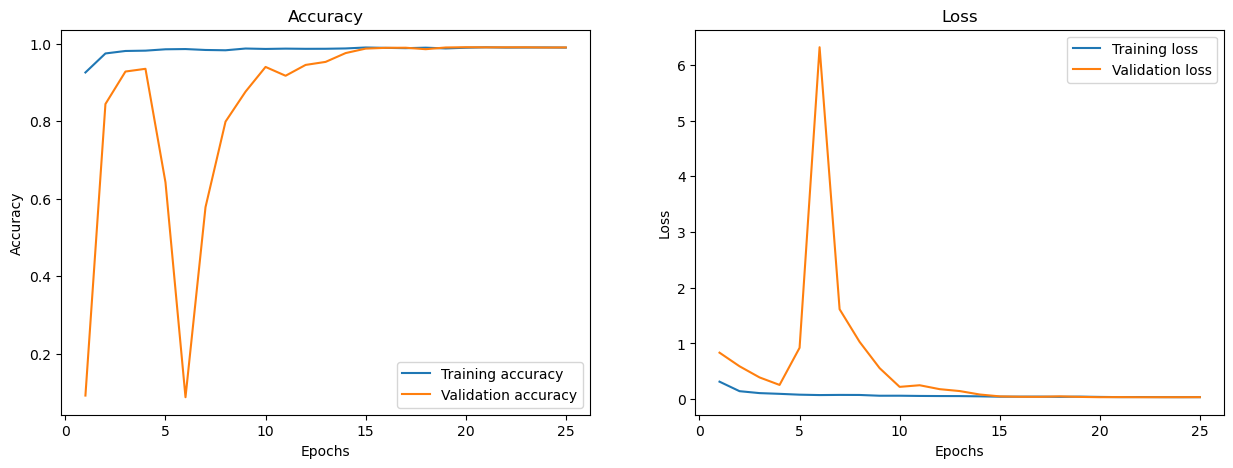

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
#Plot accuracy
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel ('Epochs')
plt.ylabel ('Accuracy')
plt.legend()
#Plot loss
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel ('Epochs')
plt.ylabel ('Loss')
plt.legend()

plt.show()

As we can see, there are large spikes in accuracy and loss early on, but the model does quite well in later epochs. One factor that may explain this fluctuation is the size of the dataset. Since it isn't particularly large, we used image generation to transform it in various ways, but these are still derivative of the original data. Perhaps with nicer generation the spikes would not be as large, or perhaps with not-so-nice generation the fluctuations would appear much wilder. This is also the reason we chose a smaller learning-rate for the Adam optimizer in our model.

In [55]:
#IOU
y_pred = model.predict(X_test)
y_pred_threshold = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_threshold)
union = np.logical_or(y_test, y_pred_threshold)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU: ", iou_score)

2/2 [==============================] - 0s 446ms/step
IoU:  0.8287155619416505


The IoU score is quite good given the epochs and steps.

We finish by taking a final look at what the model predicts compared to the true mask.

1/1 [==============================] - 0s 15ms/step


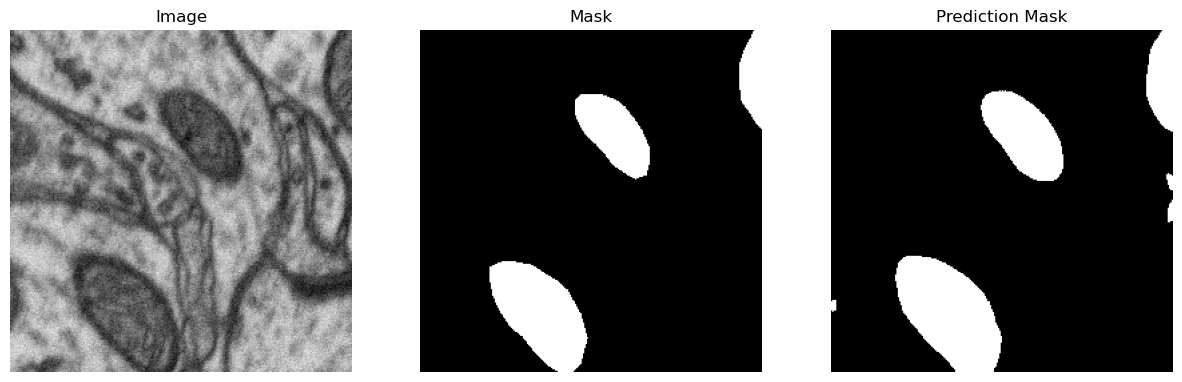

In [79]:
test_image_number = np.random.randint(0, len(X_test))
test_image = X_test[test_image_number]
true_mask = y_test[test_image_number]
test_image_norm = test_image[:,:,0][:,:,None]
test_image_input = np.expand_dims(test_image_norm, 0)
prediction = (model.predict(test_image_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_image[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(232)
plt.title('Mask')
plt.imshow(true_mask[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(233)
plt.title('Prediction Mask')
plt.imshow(prediction, cmap='gray')
plt.axis('off')

plt.show()